# Lecture : Graph Convolutional Networks

## Lab 04 : GatedGCNs -- Solution

### Xavier Bresson, Nian Liu

Bresson, Laurent, Residual Gated Graph ConvNets, 2017  
https://arxiv.org/pdf/1711.07553


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

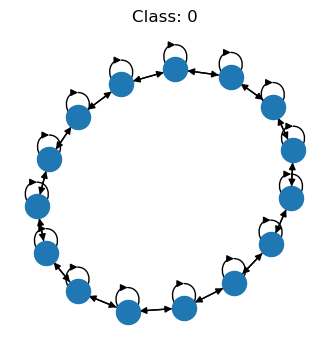

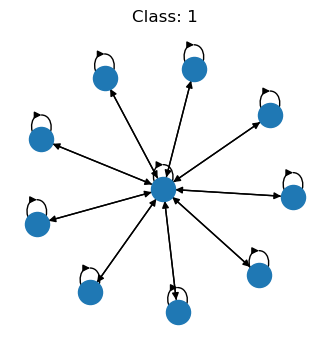

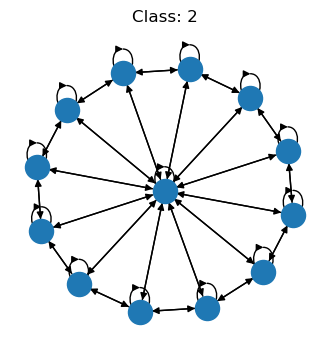

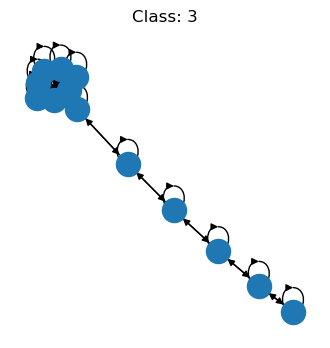

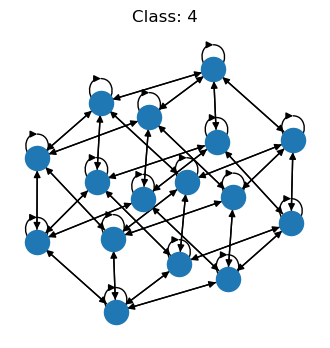

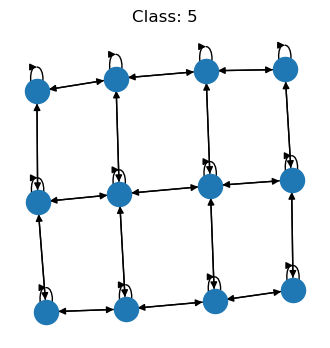

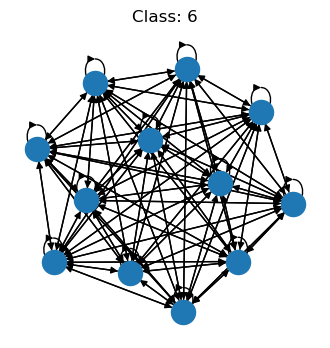

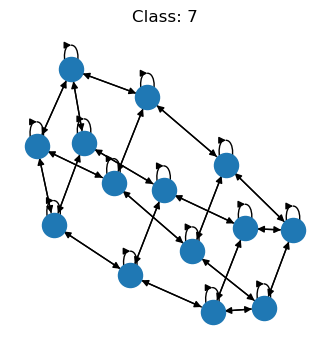

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node and edge features

In [4]:
# Add node and edge features to graphs
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feature is node in-degree
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)  # edge feature is scalar 1 (no edge info available but an input edge value is needed for edge feature update)
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [5]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    
    # Normalization w.r.t. graph sizes
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
    tab_norm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    batch_norm_n = torch.cat(tab_norm_n).sqrt()  
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
    tab_norm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    batch_norm_e = torch.cat(tab_norm_e).sqrt()
    
    return batch_graphs, batch_labels, batch_norm_n, batch_norm_e


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_norm_n, batch_norm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print('batch_norm_n:',batch_norm_n.size())
print('batch_norm_e:',batch_norm_e.size())
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=135, num_edges=947,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([4, 3, 7, 2, 7, 1, 6, 7, 5, 6])
batch_norm_n: torch.Size([135, 1])
batch_norm_e: torch.Size([947, 1])
batch_x: torch.Size([135, 1])
batch_e: torch.Size([947, 1])


## Question 1: Design the class of GatedGCN networks with DGL

Node and edge update equations:  
\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \Big( \text{BN} \Big( A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \Big) \Big), \quad \eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j'\sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon} \\
e_{ij}^{\ell+1} &=& e^\ell_{ij} + \text{ReLU} \Big( \text{BN}  \Big( C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j  \Big) \Big)
\end{eqnarray}

Instructions:

Step 1: Pass node feature and edge features along edges (src/j => dst/i) in `message_func()`.
  - Collect the updated message for `eij`: $C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j$.

Step 2: Apply `reduce_func()` to collect all messages={eij, Bhj} sent to node dst/i with Step 1.
  - Prepare the updated message for `hi`: $A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell}$.

Step 3: Finish the update for both `hi` and `eij`.



In [6]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        ########################################
        # YOUR CODE START
        # Step 1: Calculate message for `eij`, simultaneously consider `eij`, `hi` and `hj`, store `eij` as well as `Bhj` for `reduce_func
        ########################################
        Bhj = edges.src['Bh'] # Bhj with j/src
        eij = edges.data['Ce'] +  edges.dst['Dh'] + edges.src['Eh'] # Ceij + Dhi + Ehj with dst/i, src/j
        ########################################
        # YOUR CODE END
        ########################################
        edges.data['e'] = eij # update edge feature value
        return {'Bhj' : Bhj, 'eij' : eij} # send message={Bhj, eij} to node dst/i

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Bhj, eij} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        ########################################
        # YOUR CODE START
        # Step 2: Calculate message for `hi`, simultaneously consider `hj`, which is weighted by normalized `eij`
        ########################################
        Ahi = nodes.data['Ah']
        Bhj = nodes.mailbox['Bhj']
        e = nodes.mailbox['eij'] 
        sigmaij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ahi + torch.sum( sigmaij * Bhj, dim=1 ) / torch.sum( sigmaij, dim=1 ) # hi = Ahi + sum_j eta_ij * Bhj    
        ########################################
        # YOUR CODE END
        ########################################
        return {'h' : h} # return update node feature hi

    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) # linear transformation 
        g.ndata['Bh'] = self.B(h) # linear transformation 
        g.ndata['Dh'] = self.D(h) # linear transformation 
        g.ndata['Eh'] = self.E(h) # linear transformation 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) # linear transformation 
        
        g.update_all(self.message_func,self.reduce_func) # update the node and edge features with DGL
        
        h = g.ndata['h'] # collect the node output of graph convolution
        e = g.edata['e'] # collect the edge output of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        ########################################
        # YOUR CODE START
        # Step 3: batch_norm -> relu -> residual connection
        ########################################
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection  
        ########################################
        # YOUR CODE END
        ########################################
        
        return h, e
    
    
class GatedGCN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)
print(net)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)


GatedGCN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (embedding_e): Linear(in_features=1, out_features=128, bias=True)
  (GatedGCN_layers): ModuleList(
    (0-3): 4 x GatedGCN_layer(
      (A): Linear(in_features=128, out_features=128, bias=True)
      (B): Linear(in_features=128, out_features=128, bias=True)
      (C): Linear(in_features=128, out_features=128, bias=True)
      (D): Linear(in_features=128, out_features=128, bias=True)
      (E): Linear(in_features=128, out_features=128, bias=True)
      (bn_node_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)
Number of parameters: 366856 (0.37 million)


# Train the network

In [7]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        batch_snorm_n = batch_snorm_n
        batch_snorm_e = batch_snorm_e
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)
display_num_param(net)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    if not epoch%2:
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Number of parameters: 366856 (0.37 million)


/Users/xbresson/miniconda3/envs/gnn_course/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 2.3039, train_loss: 2.0398, test_loss: 2.0556, val_loss: 2.0556
                      train_acc: 0.2600, test_acc: 0.0800, val_acc: 0.0800
Epoch 2, time 1.2382, train_loss: 1.6906, test_loss: 1.8531, val_loss: 1.8531
                      train_acc: 0.5371, test_acc: 0.1400, val_acc: 0.1400
Epoch 4, time 3.0511, train_loss: 1.4716, test_loss: 1.5575, val_loss: 1.5575
                      train_acc: 0.6771, test_acc: 0.5400, val_acc: 0.5400
Epoch 6, time 1.6954, train_loss: 1.3070, test_loss: 1.3134, val_loss: 1.3134
                      train_acc: 0.7057, test_acc: 0.7500, val_acc: 0.7500
Epoch 8, time 4.0246, train_loss: 1.1287, test_loss: 1.1297, val_loss: 1.1297
                      train_acc: 0.7743, test_acc: 0.7600, val_acc: 0.7600
Epoch 10, time 2.3467, train_loss: 0.9961, test_loss: 0.9871, val_loss: 0.9871
                      train_acc: 0.8400, test_acc: 0.8100, val_acc: 0.8100
Epoch 12, time 1.3573, train_loss: 0.8814, test_loss: 0.8578, val_loss: 0.8578
  